## Improve on algorithm

Want it to work directly on flow network and dem (no watershed delineation)

use pynhd cross section code?

# other potential improvements:
- improve centerline detection
- iterative approach
- better region from contour
- better rules for filtering profile peaks

In [75]:
import os
import rioxarray
import xrspatial
import numpy as np
import pandas as pd
import geopandas as gpd
from pygeohydro import WBD
import py3dep
from pynhd import NHD, WaterData
import pynhd
import matplotlib.pyplot as plt
import xrspatial
import whitebox
from valleys.utils import setup_wbt

In [73]:
# start with huc12
def get_dem_and_flowlines(huc12):
    print('water boundary')
    wbd = WBD("huc12")
    boundary = wbd.byids("huc12", huc12)
    boundary_reprojected = boundary.to_crs(3310)

    print('getting dem')
    dem = py3dep.get_map("DEM", boundary.geometry.iloc[0], resolution=10, geo_crs=boundary.crs, crs=4326)
    dem = dem.rio.reproject(3310)

    print('flowlines medium resolution')
    nhd_mr = NHD("flowline_mr")
    flowlines_mr = nhd_mr.bygeom(boundary.geometry.iloc[0].bounds)
    flowlines_mr = flowlines_mr.to_crs(3310)
    flowlines_mr = flowlines_mr.clip(boundary_reprojected.geometry.iloc[0])

    print('flowlines high resolution')
    nhd_hr = NHD("flowline_hr")
    flowlines_hr = nhd_hr.bygeom(boundary.geometry.iloc[0].bounds)
    flowlines_hr = flowlines_hr.to_crs(3310)
    flowlines_hr = flowlines_hr.clip(boundary_reprojected.geometry.iloc[0])
    return dem, flowlines_mr, flowlines_hr

In [74]:
wbt = setup_wbt("/Users/arthurkoehl/opt/WBT/", "/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/")

In [31]:
dem, flow, flow_hr = get_dem_and_flowlines(180600060101)
hs = xrspatial.hillshade(dem)
slope = xrspatial.slope(dem)
curvature = xrspatial.curvature(dem)

water boundary
getting dem


/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/Users/arthurkoehl/Library/Caches/pypoetry/virtualenvs/valleys-apqonAG6-py3.10/lib/python3.10/site-packages/xarray/core/dataarray.py:905: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


flowlines medium resolution
flowlines high resolution


In [89]:
# save streams to wb_outputs
# save dem to wb_outputs
stream_file = "/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams.shp"
dem_file = "/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/dem.tif"
flow.to_file(stream_file)
flow_hr.to_file("/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams_hr.shp")
dem.rio.to_raster(dem_file)
wbt.rasterize_streams(streams = stream_file, base=dem_file, output='streams.tif')

wbt.elevation_above_stream_euclidean(dem_file, 'streams.tif', 'hand.tif')
hand = rioxarray.open_rasterio("/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/hand.tif")
streams = rioxarray.open_rasterio("/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams.tif")

/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_9864/1104257998.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow.to_file(stream_file)
/var/folders/l2/9h6xd6f555321vx3s_ttqb_80000gn/T/ipykernel_9864/1104257998.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  flow_hr.to_file("/Users/arthurkoehl/programs/pasternack/valleys/data/wb_outputs/streams_hr.shp")


<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

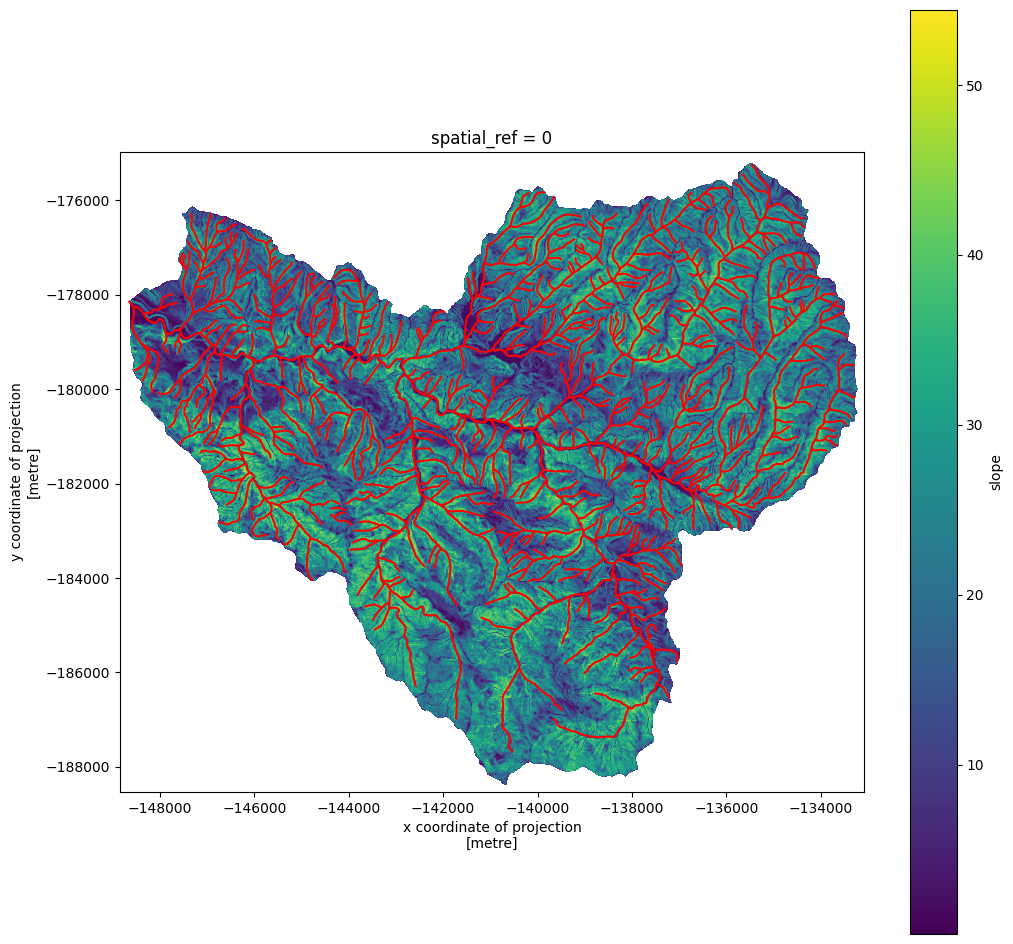

In [88]:
fig, ax = plt.subplots(figsize=(12,12))
slope.plot(ax=ax)
flow_hr.plot(ax=ax, color='red')

In [64]:
# get points on cross section 
from valleys.cross_section import get_cross_section_points
points = []
for ind,row in flow.iterrows():
    xs_points = get_cross_section_points(row['geometry'], xs_spacing=100, xs_width=300, xs_point_spacing=50)
    xs_points['comid'] = row['COMID']
    points.append(xs_points)
points = pd.concat(points)

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

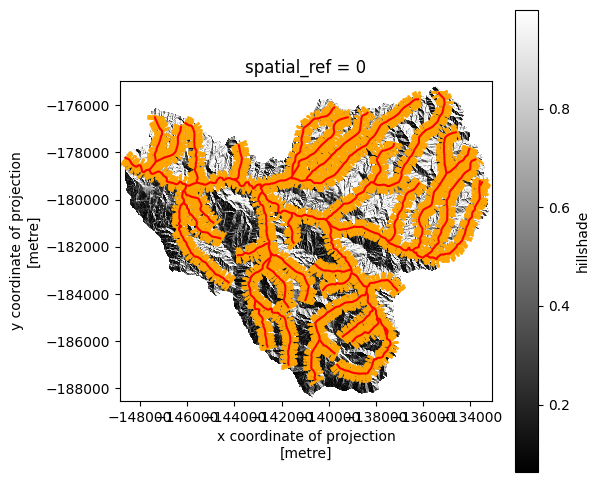

In [70]:
fig, ax = plt.subplots(figsize=(6,6))
hs.plot(ax=ax, cmap='gray')
flow.plot(ax=ax, color='red')
points.plot(ax=ax, markersize=1, color='orange')

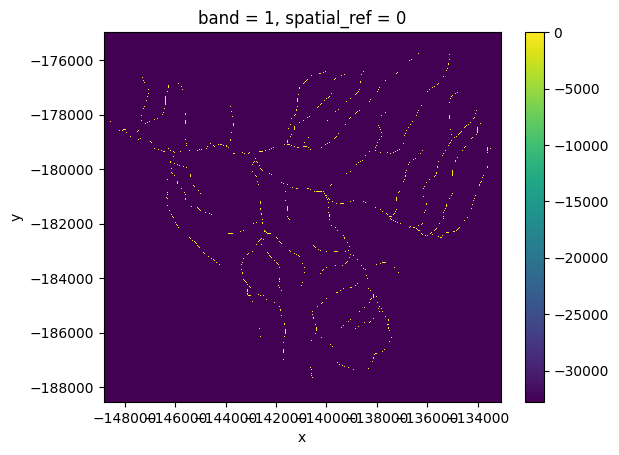

In [87]:
hand.plot()

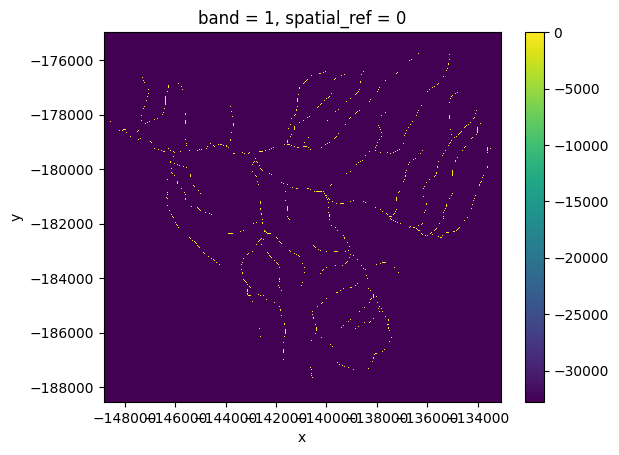

In [84]:
hand.plot()